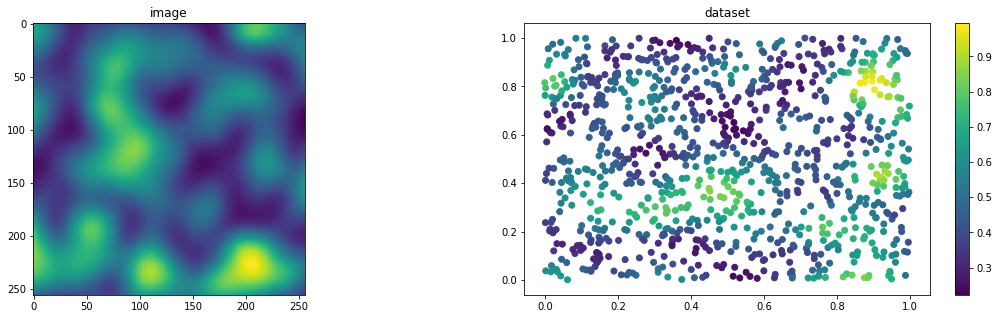

(1000, 2) (1000, 1)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import cv2
img = cv2.imread('dataset.jpg',0)
img = img/np.max(img)

def dataset(x_num):
    
    X = np.random.random(size=(x_num, 2))
    
    
    x1_max, x1_min, x2_max, x2_min = np.max(X[:, 0]), np.min(X[:, 0]), np.max(X[:, 1]), np.min(X[:, 1])
    x_max, x_min = np.array([x1_max, x2_max]), np.array([x1_min, x2_min])
    def f(x):
        coords = ((np.array(img.shape)-1)*(x-x_min)/(x_max-x_min)).astype(np.int)
        return img[coords[0], coords[1]]
    
    y = np.array([f(x) for x in X])
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1, 2, 2)
    plt.title('dataset')
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.colorbar()
    plt.show()
    
    return X, y.reshape((-1, 1))
X, y = dataset(1000);
print(X.shape, y.shape)

In [3]:
class RBF_net:
    def __init__(self, samplers=None, constant_samplers=False):
        self.samplers = samplers
        self.samplers_num = -1
        self.constant_samplers = constant_samplers
        self.initialized = False
        
        
    
    def create_net(self):
        tf.reset_default_graph()        
        assert self.samplers_num != 1, 'samplers must be a positive integer. took {} instead'.format(self.samplers)
        
        # variables
        if self.constant_samplers:
            self.centers = tf.constant(self.samplers)
        else:
             self.centers = tf.Variable(self.samplers)
        self.gammas = tf.Variable(np.random.random((self.samplers_num)))
        self.weights = tf.Variable(np.random.random((self.samplers_num, self.output_dimensions)))
        
        # placeholders
        self.x = tf.placeholder(tf.float64, (self.input_dimensions))
        self.y = tf.placeholder(tf.float64, (self.output_dimensions))
        
        # internal computations
        dists = tf.sqrt(tf.reduce_sum(tf.square(self.x-self.centers), axis=1))
        normalized = tf.reshape(tf.multiply(dists, self.gammas), shape=(1, self.samplers_num))
        self.output = tf.matmul(normalized, self.weights)
        
        # training computations
        cost = tf.abs(self.output-self.y)
        self.train = tf.train.GradientDescentOptimizer(10e-3).minimize(cost) 
        
        # init
        self.init_op = tf.global_variables_initializer()

        self.sess = tf.Session()
        self.sess.run(self.init_op)
        
    
    def predict(self, X):
        return self.sess.run(self.output, feed_dict={self.x:X})[0]
            
    def partial_fit(self, X, y):
        if not self.initialized:
            self.input_dimensions = X.shape[0]
            self.output_dimensions = y.shape[0]

            if self.samplers is not None:
                # if samplers parameter is set
                if isinstance(self.samplers, int):
                    # if samplers parameter is integer
                    if self.samplers == -1:
                        self.samplers_num = self.input_dimensions
                    else:
                        self.samplers_num = self.samplers
                    
                    self.samplers = np.random.random((self.samplers_num, self.input_dimensions))
                else:
                    # if samplers parameter is array 
                    self.samplers = np.array(self.samplers)
                    self.samplers_num = len(self.samplers)
            else:
                self.samplers_num = self.input_dimensions
                self.samplers = np.random.random((self.samplers_num, self.input_dimensions))
            
            
            
            assert self.output_dimensions == 1, 'Not tested for more than 1 output dimensions'
            assert self.input_dimensions == self.samplers.shape[1], 'Samplers dimensions don\'t match with input dimensions'
            
            print('RBF net init in({}) samplers({}) out({})'.format(self.input_dimensions, self.samplers_num, self.output_dimensions))
            self.create_net()
            self.initialized = True
        
        self.sess.run(self.train, feed_dict={self.x:X, self.y:y})
        
    def info(self):
        centers = self.sess.run(self.centers)
        gammas = self.sess.run(self.gammas)
        weights = self.sess.run(self.weights)
        
        return centers, gammas, weights


In [4]:
net = RBF_net(100, constant_samplers=False)
epochs = 50

error_hist = []
infos = []
for epoch in range(epochs):
    preds = np.empty(y.shape)
    errors = np.empty(y.shape)
    for i in range(len(X)):
        net.partial_fit(X[i], y[i])
        pred = net.predict(X[i])
        preds[i] = pred

        error = np.abs(y[i]-pred)
        errors[i] = error
    mean_error = errors.mean()
    infos.append(net.info())
    print("Epoch {}, mean error {}".format(epoch, mean_error))
    error_hist.append(mean_error)

RBF net init in(2) samplers(100) out(1)
Epoch 0, mean error 0.5752145841774671
Epoch 1, mean error 0.09027718092447908
Epoch 2, mean error 0.08478098967469731
Epoch 3, mean error 0.08430694330029949
Epoch 4, mean error 0.07928117619387502
Epoch 5, mean error 0.07767382548316744
Epoch 6, mean error 0.07985136203687593
Epoch 7, mean error 0.07608488561217812
Epoch 8, mean error 0.07345426749236553
Epoch 9, mean error 0.0747222407253474
Epoch 10, mean error 0.07534613622466059
Epoch 11, mean error 0.0712683421961808
Epoch 12, mean error 0.07170851119511307
Epoch 13, mean error 0.0727071383584775
Epoch 14, mean error 0.07068088896152819
Epoch 15, mean error 0.07026697029318038
Epoch 16, mean error 0.0677676895815562
Epoch 17, mean error 0.07009082268804857
Epoch 18, mean error 0.06894383250012232
Epoch 19, mean error 0.06886876905046443
Epoch 20, mean error 0.06879559608964186
Epoch 21, mean error 0.06882726134259888
Epoch 22, mean error 0.06591414483974126
Epoch 23, mean error 0.067921164

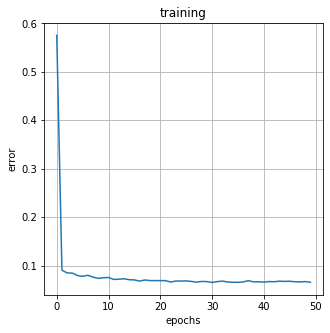

In [5]:
plt.figure(figsize=(5, 5))
plt.plot(error_hist)
plt.title('training')
plt.xlabel("epochs")
plt.ylabel("error")
plt.grid()

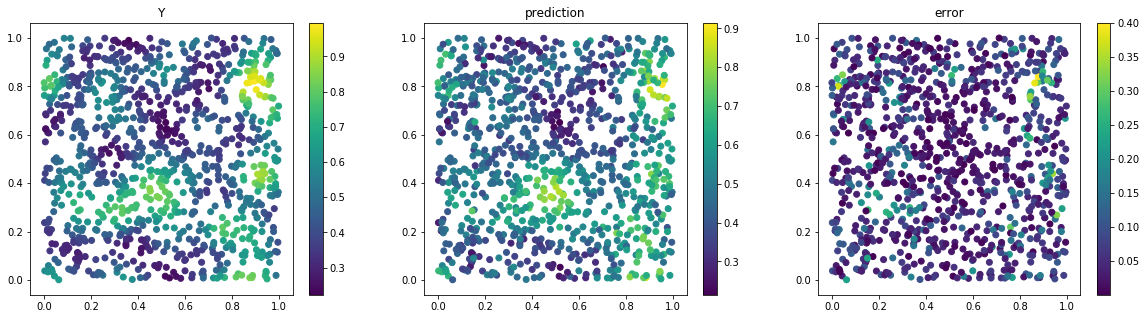

In [6]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.title('Y')
plt.scatter(X[:,0], X[:,1], c=np.reshape(y, (y.shape[0])))
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title('prediction')
plt.scatter(X[:,0], X[:,1], c=np.reshape(preds, (preds.shape[0])))
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title('error')
plt.scatter(X[:,0], X[:,1], c=np.reshape(errors, (errors.shape[0])))
plt.colorbar()
plt.show()

In [7]:
centers, gammas, weights = [], [], []
for c, g, w in infos:
    centers.append(c)
    gammas.append(g)
    weights.append(w[:, 0])
    
centers = np.array(centers)
gammas = np.array(gammas)
weights = np.array(weights)
print('Shapes: centers {}, gammas {}, weights {}'.format(centers.shape, gammas.shape, weights.shape))
centers_num = centers.shape[1]
gammas_num = gammas.shape[1]
weights_num = weights.shape[1]

Shapes: centers (50, 100, 2), gammas (50, 100), weights (50, 100)


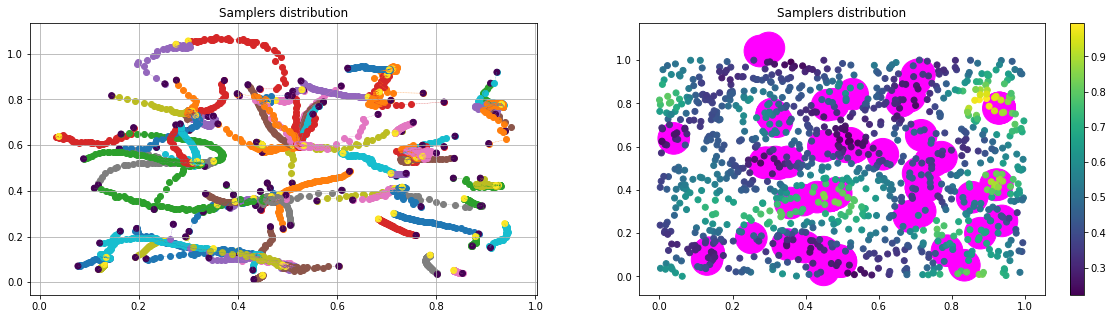

In [8]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
for c in range(centers_num):
    center = centers[:, c, :]
    plt.scatter(center[:,0],
                center[:,1],
                label=str(c))
    plt.plot(center[:,0], center[:,1], '--', linewidth=.3)
    plt.scatter(center[0::len(center)-1,0],
                center[0::len(center)-1,1],
                c=np.arange(2))

if centers_num<20:
    plt.legend()
plt.grid(True)
plt.title('Samplers distribution')

plt.subplot(1, 2, 2)
plt.scatter(centers[centers.shape[0]-1, :, 0],
            centers[centers.shape[0]-1, :, 1],
            cmap='spring',
            c=[125]*centers_num,
            s=1000,
            marker='o')

plt.scatter(X[:,0], X[:,1], c=np.reshape(y, (y.shape[0])))
plt.colorbar()    
plt.title('Samplers distribution')

plt.show()

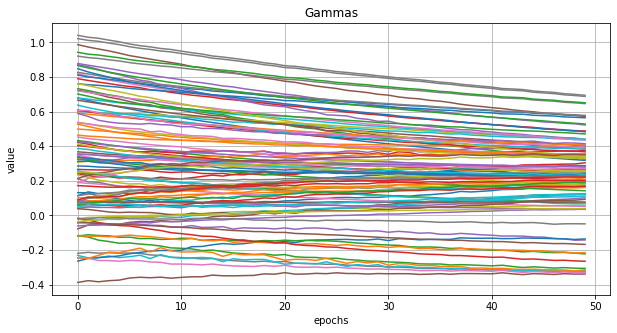

In [9]:
plt.figure(figsize=(10, 5))
for g in range(gammas_num):
#     plt.subplot(1, gammas_num, g+1)
    gamma = gammas[:, g]
    plt.plot(gamma, label=str(g))

if gammas_num<20:
    plt.legend()
plt.title("Gammas")
plt.xlabel('epochs')
plt.ylabel('value')
plt.grid(True)
plt.show()

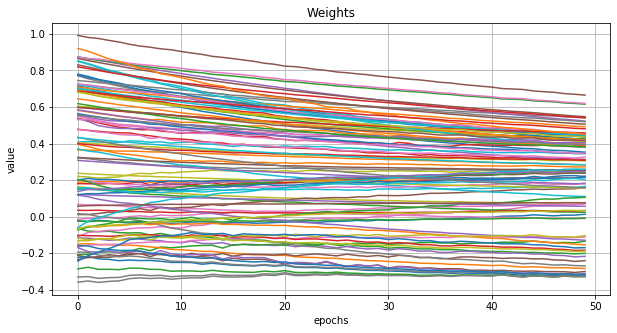

In [10]:
plt.figure(figsize=(10, 5))
for w in range(weights_num):
    weight = weights[:, w]
    plt.plot(weight, label=str(w))

if weights_num<20:
    plt.legend()
plt.title("Weights")
plt.xlabel('epochs')
plt.ylabel('value')
plt.grid(True)
plt.show()

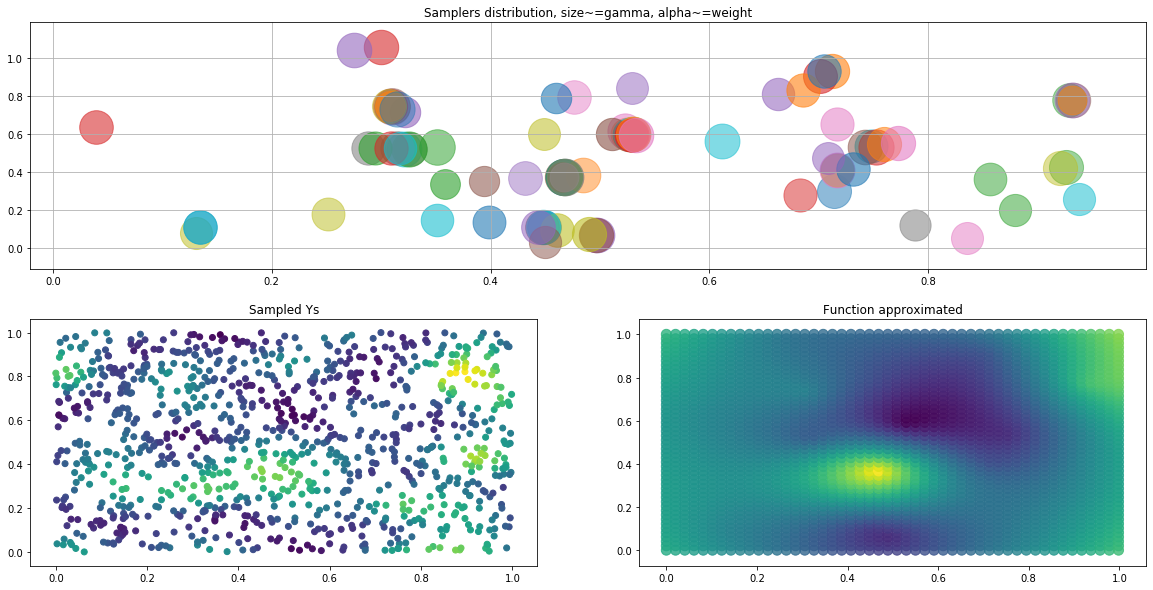

In [11]:
final_centers = centers[centers.shape[0]-1, :, :]
final_gammas = gammas[gammas.shape[0]-1]
final_weights = weights[weights.shape[0]-1]

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
for i in range(final_centers.shape[0]):
    c, g, w = final_centers[i], final_gammas[i], final_weights[i]
    plt.scatter(c[0], c[1], s=1000+g*500, alpha=0.5+w*0.25, label=str(i))

plt.title('Samplers distribution, size~=gamma, alpha~=weight')
plt.grid(True)

plt.subplot(2, 2, 4)
x_range = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 50)
y_range = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 50)
xs = np.array([np.array([x, y]) for x in x_range for y in y_range])
ys = np.array([net.predict(x)[0] for x in xs])
plt.scatter(xs[:, 0], xs[:, 1], s=100, alpha=0.8, c=ys)
plt.title('Function approximated')


plt.subplot(2, 2, 3)
plt.scatter(X[:,0], X[:,1], c=np.reshape(y, (y.shape[0])))
plt.title('Sampled Ys')

plt.show()